In [1]:
import numpy as np
import pandas as pd
import json

In [2]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

In [3]:
SYMBOLS = ['BANANAS','PEARLS','COCONUTS','PINA_COLADAS']
LOG_DIR = 'round2_logs/'

In [4]:
p = 'PEARLS'
b = 'BANANAS'

# DATA LOADING

In [5]:
def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def load_hist_quote_data(files):
    md = [pd.read_csv(f,sep=';') for f in files]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['profit_and_loss'], inplace=True)
    rename_columns = {'product':'symbol', 'bid_price_1': 'bid', 'ask_price_1': 'ask', 
                      'bid_volume_1':'bid_sz', 'ask_volume_1': 'ask_sz', 
                      'bid_price_2':'bid_2','bid_volume_2':'bid_sz_2','ask_price_2':'ask_2','ask_volume_2':'ask_sz_2',
                      'bid_price_3':'bid_3','bid_volume_3':'bid_sz_3','ask_price_3':'ask_3','ask_volume_3':'ask_sz_3'}
    md.rename(columns=rename_columns, inplace=True)
    for i in [4, 5]:
        for col in ['bid','ask']:
            md[f'{col}_{i}'] = np.nan
            md[f'{col}_sz_{i}'] = np.nan

    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def load_hist_trade_data(files,hist_days):
    md = [pd.read_csv(f,sep=';') for f in files]
    for i in range(len(hist_days)):
        md[i]['day'] = hist_days[i]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['buyer', 'seller'], inplace=True)
    md = md[md.price > 0].copy()
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def combine_hist_quote_trades(hist_quotes, hist_trades):
    """ Join data frames together
    """
    for sym in SYMBOLS:
        quotes = hist_quotes[sym]
        trades = hist_trades[sym]
        # Join quote data to trades
        trades = trades.merge(quotes, how='left', on=['symbol','day','timestamp'])

        # Summarize state by state trade data
        trades['notional'] = trades['price']*trades['quantity']
        trades_grp = trades.groupby(['symbol','day','timestamp']).agg({
            'quantity':'sum', 'notional':'sum',})
            # 'buy_vol':'sum', 'sell_vol':'sum','grey_vol':'sum'})
        trades_grp['vwap'] = trades_grp['notional']/trades_grp['quantity']
        trades_grp['trades'] = trades.groupby(['symbol','day','timestamp']).size()
        trades_grp = trades_grp.rename(columns={'quantity':'volume'})
        
        # Join trade data to quote
        quotes = quotes.merge(trades_grp.reset_index(), how='left')
        for col in ['volume', 'notional','trades']:
            quotes[col].fillna(0, inplace=True)
        quotes.loc[quotes.vwap.isna(), 'vwap'] = quotes.loc[quotes.vwap.isna(), 'mid_price']
        
        # Update
        hist_quotes[sym] = quotes
        hist_trades[sym] = trades
    
    return hist_quotes, hist_trades

def load_hist_data(quote_files, trade_files, hist_days):
    hist_quotes = load_hist_quote_data(quote_files)
    hist_trades = load_hist_trade_data(trade_files, hist_days)
    
    hist_quotes, hist_trades = combine_hist_quote_trades(hist_quotes, hist_trades)
    return hist_quotes, hist_trades

In [6]:
def quote_levels_feature(quote):
    quote['bid_levels'] = 1
    quote['ask_levels'] = 1
    
    for i in range(2,6):
        quote.loc[quote[f'bid_{i}'].notna(), 'bid_levels'] += 1
        quote.loc[quote[f'ask_{i}'].notna(), 'ask_levels'] += 1
    
    return

def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

def quote_weighted_px_full_trade_notional(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask + quote.notional
    size = quote.bid_sz + quote.ask_sz + quote.volume
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

def quote_weighted_px_skip_top(quote, levels=5):
    notional, size = 0, 0
    
    if quote['bid_sz'] >= 5:
        notional += quote.bid_sz*quote.bid
        size += quote.bid_sz
    if quote['ask_sz'] >= 5:
        notional += quote.ask_sz*quote.ask
        size += quote.ask_sz

    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

In [7]:
MOVING_WINDOW_TIMES = [5, 10, 25, 50]
HIST_PX_TIMES = [1, 5, 10, 20, 30, 50]
FUTURE_TIMES = [1, 5, 10, 25, 50, 100]

def quote_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in MOVING_WINDOW_TIMES:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    md['fair_v2'] = md.apply(quote_weighted_px_full, axis=1, args=[2])
    md['fair_v3'] = md['vwap']
    md['fair_v4'] = md.apply(quote_weighted_px_full_trade_notional, axis=1)
    
    for t in HIST_PX_TIMES:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'bid_move_{t}'] = md.bid-md.bid.shift(t)
        md[f'ask_move_{t}'] = md.ask-md.ask.shift(t)
        
        md[f'px_move_{t}'].fillna(0, inplace=True)
        md[f'bid_move_{t}'].fillna(0, inplace=True)
        md[f'ask_move_{t}'].fillna(0, inplace=True)
        
        md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)
    # Volume    
    for t in MOVING_WINDOW_TIMES:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    
    ############# Future
    # Future prices
    for t in FUTURE_TIMES:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.ask
    for t in FUTURE_TIMES:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    md['fvolume'] = md['volume'].shift(-1)
    for t in MOVING_WINDOW_TIMES:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    md['total_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].sum(axis=1)
    md['max_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].max(axis=1)
    md['total_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].sum(axis=1)
    md['max_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].max(axis=1)
    
    md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
    md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1, 2, 3, 4]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
        for t in HIST_PX_TIMES:
            md[f'fair_v{v}_move_{t}'] = md[f'fair_v{v}']-md[f'fair_v{v}'].shift(t)
            
    
    md['bid_improve'] = md['bid'] > md['bid'].shift(1)
    md['bid_revert'] = md['bid'] < md['bid'].shift(1)
    md['ask_improve'] = md['ask'] < md['ask'].shift(1)
    md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return md

In [26]:
def hist_data_summary(hist_quotes, hist_trades):
    for sym in SYMBOLS:
        print(sym)
        quote = hist_quotes[sym]
        quote_summary = quote.agg({
            'spread':['mean','std'], 'mid_price': ['mean','std'], 'px_move_10': ['mean','std'], 'px_move_50': ['mean','std'],
            'volume':['sum', 'mean'], 'trades':['sum', 'mean'],
            'bid_sz': 'mean', 'ask_sz':'mean', 
            'bid_levels':'mean', 'ask_levels':'mean',
            'bid_sz_2':'mean', 'ask_sz_2':'mean',
            'bid_sz_3':'mean', 'ask_sz_3':'mean',
        }).round(2)
        display(quote_summary)

## Load

In [22]:
data_dir = 'hist_data/island-data-bottle-round-2/'
hist_days = [-1, -1, 1]
quote_files = [f'{data_dir}prices_round_2_day_{i}.csv' for i in hist_days]
trade_files = [f'{data_dir}trades_round_2_day_{i}_nn.csv' for i in hist_days]

hist_quotes, hist_trades = load_hist_data(quote_files, trade_files, hist_days)
for sym in SYMBOLS:
    hist_quotes[sym] = quote_preprocess(hist_quotes[sym])

In [27]:
hist_data_summary(hist_quotes, hist_trades)

BANANAS


,spread,mid_price,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,5.25,4892.99,-0.04,-0.21,2.44,0.87,17.54,18.01,1.41,1.4,23.23,22.5,24.63,24.48
std,1.90,45.84,2.29,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,73311.00,26080.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PEARLS


,spread,mid_price,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,6.78,9999.99,-0.0,0.0,1.54,0.72,8.26,8.21,1.91,1.92,19.71,19.69,23.13,23.11
std,2.47,1.49,2.1,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,46320.00,21589.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


COCONUTS


,spread,mid_price,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,2.47,7999.56,-0.02,-0.12,2.85,0.12,154.56,155.19,1.24,1.25,135.3,131.44,128.98,125.19
std,0.61,64.30,3.92,8.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,85365.00,3451.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PINA_COLADAS


,spread,mid_price,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,2.65,14997.52,-0.05,-0.26,0.8,0.08,71.32,71.52,1.35,1.35,64.86,64.35,62.4,62.78
std,0.59,101.21,8.89,19.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,24092.0,2545.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TRADING LOG LOADING

In [11]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})")
    # orders_depth_regex = re.compile(r"(\d+) ORDER_DEPTHS (\{.*\})")
    # market_trades_regex = re.compile(r"(\d+) MARKET_TRADES (\{.*\})")
    # own_trades_regex = re.compile(r"(\d+) OWN_TRADES (\{.*\})")
    # position_regex = re.compile(r"(\d+) POSITION (\{.*\})")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")
    empty_regex = re.compile(r"(\d+) \$")
    
    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
            match = empty_regex.match(l)
            if match:
                trading_states.append(match.group(1))
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": -1, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            
    positions = pd.DataFrame(positions)
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    for p in SYMBOLS:
        if p not in pos:
            positions.append({"timestamp": state['timestamp'], "symbol": p, "position": 0})
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100:
                market_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return

def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """ 
    # Side refers to side of algo
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    return df

def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    Experimental - NOT SURE IF THIS IS GOING TO BE HELPFUL
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    # trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    # trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    # trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    for col in ['volume', 'notional','trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote

def combine_quote_algo_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), on=['symbol','timestamp'], how='left', suffixes=('','_algo'))
    
    for col in ['volume_algo', 'notional_algo', 'trades_algo']:
        quote[col].fillna(0, inplace=True)
    
    return quote

def fill_active(x):
    if x['side'] == 1:
        # Buy
        return x['price'] >= x['ask']
    else:
        return x['price'] <= x['bid']

def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.apply(fill_active, axis=1)
    fills['active_qty'] = fills['active']*fills['quantity']
    fills['passive_qty'] = (~fills['active'])*fills['quantity']

    fill_data = fills.groupby(['symbol','timestamp','price', 'side'])[['quantity','active_qty','passive_qty']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    orders = orders.merge(fill_data, how='left', on=['symbol','timestamp','price','side'])
    for col in ['fill_qty','active_qty','passive_qty']:
        orders[col].fillna(0, inplace=True)
    orders['fill_pct'] = np.abs(orders['fill_qty']/orders['quantity'])
    
    return orders

# PnL, Position, Volume Traded, Notional Traded, VWAP
def trading_performance(positions, own_trades, quote):
    positions = positions.merge(quote[['timestamp','symbol','mid_price']], on=['symbol','timestamp']) # Add mid price
    own_trades['trades'] = 1
    own_trades['notional'] = own_trades['price']*own_trades['quantity']
    own_trades.rename(columns={'quantity':'qty'},inplace=True)
    vol_cols = []
    for col in ['qty','notional','trades']:
        own_trades[f'buy_{col}'] = own_trades[col]
        own_trades[f'sell_{col}'] = own_trades[col]
        own_trades.loc[own_trades['side'] == -1, f'buy_{col}'] = 0
        own_trades.loc[own_trades['side'] == 1, f'sell_{col}'] = 0
        vol_cols += [col, f'buy_{col}',f'sell_{col}']
    own_trades_g = own_trades.groupby(['symbol','timestamp'])[vol_cols].sum()

    positions = positions.merge(own_trades_g.reset_index(), how='left', on=['symbol','timestamp'])
    for col in vol_cols:
        positions[col].fillna(0, inplace=True)
        positions[f'total_{col}'] = positions.groupby(['symbol'])[col].cumsum()
    positions['pnl'] = (positions['total_sell_notional']-positions['total_buy_notional']) \
            - positions['mid_price']*(positions['total_sell_qty']-positions['total_buy_qty'])

    positions = positions.copy()
    return positions

def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    
    quote = combine_quote_trades(quote, market_trades.copy())
    quote = combine_quote_algo_trades(quote, own_trades.copy())

    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    order_depths = combine_quote_algo_trades(order_depths, own_trades.copy())
    
    positions = trading_performance(positions, own_trades.copy(), quote) 
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['order_depths'] = order_depths
    dfs['quote'] = quote
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    
    if by_symbol:
        for table in dfs:
            dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs

In [12]:
fig_size = (6,3)

def plot_intraday(dfs, col):
    f, ax = plt.subplots(figsize=fig_size)
    for product in dfs:
        ax.plot("timestamp", col, data=dfs[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.legend()
    return

def plot_quote(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "bid", data=md, color="red")
    ax.plot("timestamp", "ask", data=md, color="blue")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (Seashells)")
    ax.set_title(sym)
    return

def trading_simulation_summary(dfs):
    total_pnl = 0
    for sym in SYMBOLS:
        trade_perf = dfs['positions'][sym].iloc[-1]
        pnl = trade_perf['pnl']
        total_pnl += pnl
        market_volume = dfs['market_trades'][sym]['quantity'].sum()
        trade_count = trade_perf['total_trades']
        trade_volume = trade_perf['total_qty']
        vol_per_step = dfs['positions'][sym]['qty'].mean()

        print("""{}: PnL={} | Trades={} | MarketVol={} | Volume Filled={} | POV={:.2} | Shares/Step={:.3} | PnL/Share={:.4}""".format(sym, \
            pnl, trade_count, market_volume, trade_volume,trade_volume/(market_volume+trade_volume), vol_per_step, pnl/trade_volume))
    print("Total PnL={}".format(total_pnl))
    plot_intraday(dfs['positions'], 'pnl')
    plot_intraday(dfs['positions'], 'position')

## Load

BANANAS: PnL=1823.0 | Trades=273.0 | MarketVol=310 | Volume Filled=864.0 | POV=0.74 | Shares/Step=0.865 | PnL/Share=2.11
PEARLS: PnL=1587.0 | Trades=273.0 | MarketVol=191 | Volume Filled=712.0 | POV=0.79 | Shares/Step=0.713 | PnL/Share=2.229
COCONUTS: PnL=0.0 | Trades=0.0 | MarketVol=1444 | Volume Filled=0.0 | POV=0.0 | Shares/Step=0.0 | PnL/Share=nan
PINA_COLADAS: PnL=0.0 | Trades=0.0 | MarketVol=488 | Volume Filled=0.0 | POV=0.0 | Shares/Step=0.0 | PnL/Share=nan
Total PnL=3410.0


C:\Users\TangSan\AppData\Local\Temp/ipykernel_26536/1999926234.py:33: RuntimeWarning: invalid value encountered in double_scalars
  pnl, trade_count, market_volume, trade_volume,trade_volume/(market_volume+trade_volume), vol_per_step, pnl/trade_volume))


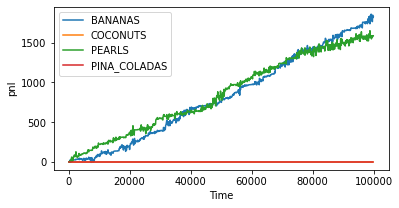

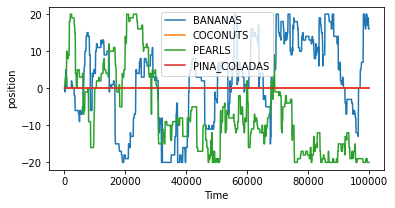

In [267]:
file_name = 'f4a98a64-1f62-4529-89e1-7c189ac51d62'
file_name = '73961af3-b38a-459b-a5fa-d6bec4efde72'
file_name = 'e6074822-e820-44f6-9173-e2e828968a06'

log_file = LOG_DIR + file_name + '.log'
dfs = load_data_from_log(log_file, True)
trading_simulation_summary(dfs)

# Trading Log Analytics

In [254]:
def algo_spread(x):
    bid = np.fmax(x['price_algo_buy'], x['bid'])
    ask = np.fmin(x['price_algo_sell'], x['ask'])
    return ask-bid

algo_market_cols = ['symbol', 'timestamp', 'price_algo_buy', 'price_algo_sell','algo_spread']
def get_algo_market(orders, quote):
    buy_orders = orders.loc[orders.side == 1].copy()
    sell_orders = orders.loc[orders.side == -1].copy()

    buy_spread = buy_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    buy_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='last') # keep most aggressive
    sell_spread = sell_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    sell_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='first')
    
    algo_market = buy_spread.merge(sell_spread, how='outer', on=['symbol','timestamp'], suffixes=['_algo_buy','_algo_sell'])
    algo_market.sort_values('timestamp',inplace=True)
    algo_market = algo_market.merge(quote, how='left', on=['symbol','timestamp'])
    algo_market['spread'] = algo_market['ask'] - algo_market['bid']
    algo_market['algo_spread'] = algo_market.apply(algo_spread, axis=1)
    
    return algo_market

def order_analysis(orders):
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    orders['filled'] = orders['fill_qty'] > 0
    
    for t in FUTURE_TIMES:
        orders[f'toxicity_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['fill_qty']*orders[f'toxicity_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
        orders[f'spread_capture_{t}'] = orders[f'toxicity_{t}']/orders['spread']
    
    return

toxicity_labels, reversion_labels = [], []
for t in FUTURE_TIMES:
    toxicity_labels.append(f'toxicity_{t}')
    reversion_labels.append(f'fill_revert_{t}')

def get_orders_fills(market_trades, orders, quote):
    algo_market = get_algo_market(orders, quote)

    orders_cols = ['note', 'price', 'quantity', 'side', 'symbol', 'timestamp','fill_qty']
    fills = orders.loc[orders.fill_qty > 0]
    fills = fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    order_analysis(fills)
    fills = fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])

    missed_fills = orders[orders_cols].merge(market_trades, on=['symbol','timestamp'], suffixes=('_algo','_mkt'))
    missed_fills = missed_fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    missed_fills = missed_fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])
    
    return fills, missed_fills

In [257]:
sym = p
market_trades = dfs['market_trades'][sym]
orders = dfs['orders'][sym]
quote = dfs['order_depths'][sym].copy()
fills, missed_fills = get_orders_fills(market_trades, orders, quote)

In [258]:
fills['note'].value_counts()

X_0    167
P3      34
P2      28
P4      19
P0      11
P1       7
Name: note, dtype: int64

In [260]:
missed_fills['note'].value_counts()

P3     70
P0     32
P2     29
P4     27
X_0    26
P1     18
Name: note, dtype: int64

In [262]:
total_fills = fills.groupby(['side'])['fill_qty'].sum()
fill_win = fills.groupby(['side','note'])['fill_qty'].sum()
fill_win = fill_win
fill_win.unstack()

note,P0,P1,P2,P3,P4,X_0
side,,,,,,
-1,12.0,9.0,84.0,49.0,27.0,179.0
1,11.0,10.0,21.0,56.0,38.0,204.0


In [266]:
fills.loc[fills.note == 'P0'][['side','price','quantity','fill_qty','bid','ask','bid_2','ask_2','bid_sz','ask_sz','bid_sz_2','ask_sz_2']]

,side,price,quantity,fill_qty,bid,ask,bid_2,ask_2,bid_sz,ask_sz,bid_sz_2,ask_sz_2
41,1,9999,12,1.0,10002.0,10004.0,9998.0,10005.0,1.0,2.0,1.0,22.0
48,1,9999,12,2.0,9998.0,10004.0,9996.0,10005.0,10.0,2.0,2.0,23.0
51,1,9999,12,2.0,9998.0,10004.0,9996.0,10005.0,8.0,1.0,1.0,23.0
151,-1,10001,10,2.0,9996.0,10002.0,9995.0,10004.0,2.0,1.0,24.0,2.0
167,-1,10001,11,1.0,9996.0,10002.0,9995.0,10004.0,1.0,9.0,20.0,1.0
172,-1,10001,10,2.0,10000.0,10002.0,9996.0,10004.0,4.0,9.0,2.0,2.0
173,-1,10001,8,3.0,9996.0,10002.0,9995.0,10004.0,1.0,1.0,23.0,1.0
184,1,9999,12,1.0,9998.0,10005.0,9995.0,NaN,7.0,25.0,25.0,NaN
190,1,9999,12,5.0,9998.0,10005.0,9995.0,NaN,10.0,27.0,27.0,NaN
204,-1,10001,12,2.0,9996.0,10002.0,9995.0,10004.0,1.0,5.0,30.0,1.0


In [175]:
fills.fill_qty.describe()

count    269.000000
mean       2.646840
std        2.390474
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       12.000000
Name: fill_qty, dtype: float64

In [243]:
fills.loc[(fills.quantity > (fills.ask_sz_2)) & (fills.side == -1)][['price','quantity','fill_qty','ask','ask_sz','ask_2','ask_sz_2']]

,price,quantity,fill_qty,ask,ask_sz,ask_2,ask_sz_2
52,10001,13,1.0,10002.0,5.0,10004.0,1.0
154,10001,10,2.0,10002.0,1.0,10004.0,2.0
170,10001,11,1.0,10002.0,9.0,10004.0,1.0
175,10001,10,2.0,10002.0,9.0,10004.0,2.0
176,10001,8,3.0,10002.0,1.0,10004.0,1.0
207,10001,13,2.0,10002.0,5.0,10004.0,1.0
226,10001,5,2.0,10002.0,4.0,10004.0,2.0


In [244]:
fills.loc[(fills.quantity > (fills.bid_sz_2)) & (fills.side == 1)][['note','price','quantity','fill_qty','bid','bid_sz','bid_2','bid_sz_2','ask']]

,note,price,quantity,fill_qty,bid,bid_sz,bid_2,bid_sz_2,ask
24,P1,9999,13,2.0,9998.0,6.0,9996.0,2.0,10004.0
27,X_0,10000,6,6.0,9998.0,2.0,9996.0,2.0,10000.0
42,P0,9999,10,1.0,10002.0,1.0,9998.0,1.0,10004.0
49,P0,9999,13,2.0,9998.0,10.0,9996.0,2.0,10004.0
53,P0,9999,13,2.0,9998.0,8.0,9996.0,1.0,10004.0
96,P1,9999,13,2.0,9998.0,7.0,9996.0,1.0,10004.0
117,P3,9997,13,7.0,10002.0,1.0,9996.0,2.0,10004.0
157,X_0,10000,6,6.0,9998.0,3.0,9996.0,1.0,10000.0
232,X_0,10000,4,4.0,9998.0,6.0,9996.0,2.0,10000.0
261,P1,9999,13,1.0,9998.0,9.0,9996.0,1.0,10004.0


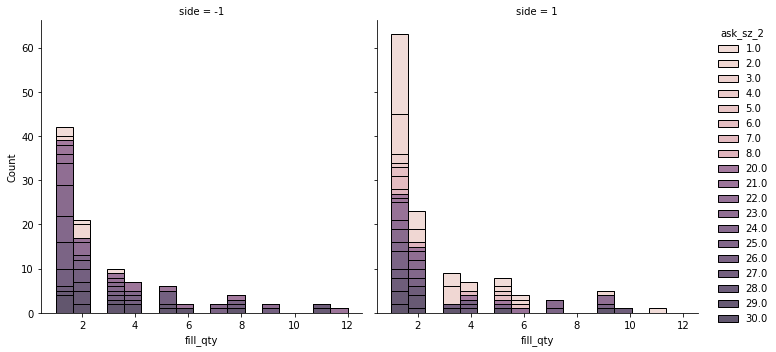

In [204]:
sns.displot(x='fill_qty', data=fills, hue='ask_sz_2', multiple='stack', col='side')

In [178]:
fills.loc[fills.note == 'P3'][['quantity', 'fill_qty']]

,quantity,fill_qty
50,20,1.0
81,20,4.0
123,20,12.0
127,20,13.0
184,20,1.0
185,20,16.0
213,20,16.0
223,20,2.0
225,20,17.0
240,20,2.0


In [148]:
missed_vol = missed_fills.groupby(['side_algo'])['quantity_mkt'].sum()
missed_vol_type = missed_fills.groupby(['side_algo','note'])['quantity_mkt'].sum()
missed_vol_type.unstack()

note,P0,P1,P2,P3,P4,X_0
side_algo,,,,,,
-1,2,6,44,76,24,28
1,27,30,15,72,34,12


In [64]:
missed_fills.columns.values

array(['note', 'price_algo', 'quantity_algo', 'side_algo', 'symbol',
       'timestamp', 'fill_qty', 'price_mkt', 'quantity_mkt', 'bid', 'ask',
       'bid_sz', 'ask_sz', 'mid_price', 'side_mkt', 'bid_levels', 'bid_q',
       'bid_sz_q', 'bid_5', 'bid_sz_5', 'bid_4', 'bid_sz_4', 'bid_3',
       'bid_sz_3', 'bid_2', 'bid_sz_2', 'ask_levels', 'ask_q', 'ask_sz_q',
       'ask_5', 'ask_sz_5', 'ask_4', 'ask_sz_4', 'ask_3', 'ask_sz_3',
       'ask_2', 'ask_sz_2', 'mid_price_q', 'volume', 'notional', 'vwap',
       'trades', 'volume_algo', 'notional_algo', 'trades_algo', 'spread',
       'return', 'mid_px_mavg5', 'mid_px_mavg5_norm', 'px_norm_mavg5',
       'mid_px_mavg10', 'mid_px_mavg10_norm', 'px_norm_mavg10',
       'mid_px_mavg25', 'mid_px_mavg25_norm', 'px_norm_mavg25',
       'mid_px_mavg50', 'mid_px_mavg50_norm', 'px_norm_mavg50',
       'quote_wgt_px_top', 'fair_v1', 'fair_v2', 'fair_v3', 'fair_v4',
       'px_move_1', 'bid_move_1', 'ask_move_1', 'px_move_1_norm',
       'log_return_

In [ ]:
def algo_spread(x):
    bid = np.fmax(x['price_algo_buy'], x['bid'])
    ask = np.fmin(x['price_algo_sell'], x['ask'])
    return ask-bid

def get_algo_market(orders, quote):
    buy_orders = orders.loc[orders.side == 1].copy()
    sell_orders = orders.loc[orders.side == -1].copy()

    buy_spread = buy_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    buy_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='last') # keep most aggressive
    sell_spread = sell_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    sell_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='first')
    
    algo_market = buy_spread.merge(sell_spread, how='outer', on=['symbol','timestamp'], suffixes=['_algo_buy','_algo_sell'])
    algo_market.sort_values('timestamp',inplace=True)
    algo_market = algo_market.merge(quote, how='left', on=['symbol','timestamp'])
    algo_market['spread'] = algo_market['ask'] - algo_market['bid']
    algo_market['algo_spread'] = algo_market.apply(algo_spread, axis=1)
    
    return algo_market

def get_orders_fills(